In [2]:
stock_file = "/root/retro_synthesis/aizynthfinder/data/zinc_stock_17_04_20.hdf5"
# 导入必要的库
import pandas as pd
from aizynthfinder.utils.files import read_datafile
from pathlib import Path

# 定义 HDF5 文件路径（替换为你的文件实际路径）
hdf5_path = Path(stock_file)  

# 使用内置函数读取 HDF5 文件
try:
    # 调用代码库中已实现的 read_datafile 函数
    data = read_datafile(hdf5_path)
    print(f"成功读取文件：{hdf5_path}")
    print(f"数据形状：{data.shape}")
    display(data.head())  # 在 Jupyter 中展示前 5 行数据
except Exception as e:
    print(f"读取文件失败：{e}")



成功读取文件：/root/retro_synthesis/aizynthfinder/data/zinc_stock_17_04_20.hdf5
数据形状：(17422831, 1)


,inchi_key
0,RYYVLZVUVIJVGH-UHFFFAOYSA-N
1,HZZVJAQRINQKSD-RQJHMYQMSA-N
2,RRTKVYSLIGQWCO-UHFFFAOYSA-N
3,YAPQBXQYLJRXSA-UHFFFAOYSA-N
4,SZPBAPFUXAADQV-UHFFFAOYSA-N


In [5]:
# 进行简单分析（根据文件内容调整）
if 'data' in locals():
    # 1. 查看数据列信息
    print("\n数据列信息：")
    print(data.columns.tolist())
    
    # 2. 统计唯一值（以 inchi_key 为例，适用于库存文件）
    if 'inchi_key' in data.columns:
        unique_count = data['inchi_key'].nunique()
        print(f"\n唯一的 InChI Key 数量：{unique_count}")
    
    # 3. 查看缺失值
    print("\n缺失值统计：")
    print(data.isnull().sum())
    
    # 4. 保存为 CSV（可选）
    output_csv = hdf5_path.with_suffix(".csv")
    # data.to_csv(output_csv, index=False)
    print(f"\n数据已保存为 CSV：{output_csv}")


数据列信息：
['inchi_key']

唯一的 InChI Key 数量：17422831

缺失值统计：
inchi_key    0
dtype: int64

数据已保存为 CSV：/root/retro_synthesis/aizynthfinder/data/zinc_stock_17_04_20.csv


# 查询速度

In [13]:
# 使用100个从原始hdf5文件抽取的分子进行查询，统计总时间，平均时间，以及时间分布直方图
# 此举是为了了测试查询一个分子所需的时间，不进行逆合成的预测
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from aizynthfinder.context.stock import Stock
from aizynthfinder.context.stock.queries import InMemoryInchiKeyQuery
from aizynthfinder.chem import Molecule , MoleculeException
from rdkit import Chem

# 1. 配置参数
HDF5_PATH = "/root/retro_synthesis/aizynthfinder/data/zinc_stock_17_04_20.hdf5"  # 替换为你的 HDF5 文件路径
SAMPLE_SIZE = 100  # 随机采样数量

# 2. 加载 HDF5 库存文件
stock = Stock()
try:
    # 创建查询实例（使用 InMemoryInchiKeyQuery 加载 HDF5）
    stock_query = InMemoryInchiKeyQuery(path=HDF5_PATH)
    # 将查询加载到 Stock 管理器
    stock.load(stock_query, "hdf5_stock")
    stock.select("hdf5_stock")  # 选择使用该库存
    print(f"成功加载库存，包含 {len(stock)} 个分子")
except Exception as e:
    print(f"加载失败: {e}")
    raise

# 3. 加载分子
file = "/root/retro_synthesis/retro_star/retro_star/dataset/uspto190_smiles.txt"
with open(file, "r") as f:
    smiles_list = [line.strip() for line in f if line.strip()]
print(f"从文件加载了 {len(smiles_list)} 个分子")
sampled_molecules = random.sample(smiles_list, min(SAMPLE_SIZE, len(smiles_list)))
print(f"随机采样了 {len(sampled_molecules)} 个分子用于查询")
molecules = []
for smi in sampled_molecules:
    try:
        mol = Molecule(smiles=smi, sanitize=True)
        molecules.append(mol)
    except MoleculeException as e:
        print(f"无效分子 SMILES: {smi}, 错误: {e}")
print(f"成功创建了 {len(molecules)} 个有效分子对象")




成功加载库存，包含 17422831 个分子
从文件加载了 190 个分子
随机采样了 100 个分子用于查询
成功创建了 100 个有效分子对象


In [17]:

# 4. 执行查询并记录时间
times = []
total_time = 0.0
is_in = []
for mol in molecules:
    start = time.perf_counter()
    # 执行 contains 检查
    query = mol in stock
    is_in.append(query)
    end = time.perf_counter()
    elapsed = (end - start) * 1000  # 转换为毫秒
    times.append(elapsed)
    total_time += elapsed
print(f"查询完成，共 {len(molecules)} 个分子")
print(f"其中 {sum(is_in)} 个分子在库存中")
# 5. 计算统计数据
avg_time = total_time / SAMPLE_SIZE
min_time = min(times)
max_time = max(times)

print(f"查询性能统计 ({SAMPLE_SIZE} 次查询):")
print(f"总时间: {total_time:.4f} 毫秒")
print(f"平均时间: {avg_time:.4f} 毫秒")
print(f"最小时间: {min_time:.4f} 毫秒")
print(f"最大时间: {max_time:.4f} 毫秒")



查询完成，共 100 个分子
其中 0 个分子在库存中
查询性能统计 (100 次查询):
总时间: 0.2391 毫秒
平均时间: 0.0024 毫秒
最小时间: 0.0017 毫秒
最大时间: 0.0248 毫秒


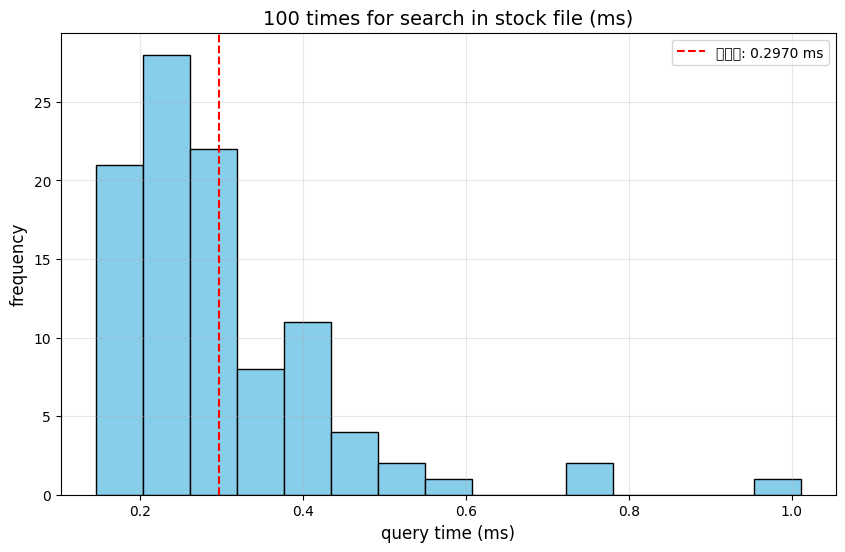

In [16]:
# 6. 绘制时间分布直方图
plt.figure(figsize=(10, 6))
plt.hist(times, bins=15, color='skyblue', edgecolor='black')
plt.title(f'{SAMPLE_SIZE} times for search in stock file (ms)', fontsize=14)
plt.xlabel('query time (ms)', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.grid(alpha=0.3)
plt.axvline(avg_time, color='red', linestyle='--', label=f'平均值: {avg_time:.4f} ms')
plt.legend()
plt.show()